In [1]:
import pandas as pd

In [491]:
full_df = pd.read_csv('../dataset/complete_dataset.csv')
full_df.drop_duplicates(subset=['IMDB_ID'], inplace=True)
full_df.dropna(subset=['text', 'year'], inplace=True)

/Users/lennartkeller/opt/anaconda3/envs/clustering/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,1,3,5,6,7,8,9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [492]:
full_df.year = full_df.year.apply(lambda x: int(x))

In [493]:
full_df.shape

(34414, 19)

In [494]:
full_df = full_df[~full_df.text.apply(lambda x: len(x) < 500)]

In [495]:
full_df = full_df[~full_df.year == 1191]

In [475]:
import re
remove_subcentral_annotation = re.compile(r'übersetzt von.+$', flags=re.I)
remove_season_episode_annotation = re.compile(r's\d+?e\d+?', flags=re.I)
remove_subcentral_note = re.compile(r'subcentral präsentiert.+$', flags=re.I)

for regex in (remove_subcentral_annotation, remove_season_episode_annotation, remove_subcentral_note):
    full_df.text = full_df.text.str.replace(regex, '')

In [496]:
full_df.year

Series([], Name: year, dtype: int64)

In [4]:
from pathlib import Path
import numpy as np
def read_embeddings(embedding_file: str):
    data = Path(embedding_file).read_text()
    lines = data.split('\n')
    filenames = []
    embeddings = []
    for line in lines:
        line_data = line.split(' ')
        if len(line_data) >=2 :
            filenames.append(line_data[0])
            embeddings.append(list(map(float, line_data[1:])))
    return np.asarray(filenames), np.asarray(embeddings)

In [5]:
filenames, embeddings_mean = read_embeddings('../dataset/embeddings_mean.txt')
max_filenames, embeddings_max = read_embeddings('../dataset/embeddings_max.txt')
filenames, embeddings_min = read_embeddings('../dataset/embeddings_min.txt')

In [6]:
filenames.shape, embeddings_mean.shape, max_filenames.shape, embeddings_max.shape, embeddings_min.shape

((34491,), (3729, 300), (68982,), (68982, 300), (34491, 300))

In [427]:
df = full_df[full_df['filename'].isin(max_filenames)].copy()
df.shape

(34491, 19)

In [8]:
# check if everything is in right order for joining data
(df.filename == filenames).all()

True

In [9]:
#df['embedding'] = [e for e in embeddings]

In [10]:
df.head()

,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
0,6584498.xml,( Rückblick ) Waren Sie neulich mit uns in die...,tt1147427,"Comedy,Family,Romance",NaN,NaN,untokenisiert,NaN,nm0240047,nm0226201,tvEpisode,Príbeh séfova zástupce,Príbeh séfova zástupce,0.0,NaN,NaN,NaN,NaN,NaN
1,6977710.xml,FÜNF FREUNDE FÜR ALLE FÄLLE FÜNF FREUNDE FÜR A...,tt1294864,"Animation,Comedy",NaN,NaN,untokenisiert,NaN,NaN,"nm0509769,nm0537542,nm0875635",tvEpisode,The Case of Allie's Really Very Bad Singing,The Case of Allie's Really Very Bad Singing,0.0,NaN,NaN,22,NaN,NaN
3,6977706.xml,FÜNF FREUNDE FÜR ALLE FÄLLE FÜNF FREUNDE FÜR A...,tt1294865,"Animation,Comedy",NaN,NaN,untokenisiert,NaN,NaN,"nm0537542,nm0875635",tvEpisode,"The Case of the Impolite, Snarly Thing","The Case of the Impolite, Snarly Thing",0.0,NaN,NaN,22,NaN,NaN
4,6979067.xml,FÜNF FREUNDE - FÜR ALLE FÄLLE FÜNF FREUNDE - F...,tt1328700,"Animation,Comedy",NaN,NaN,untokenisiert,NaN,NaN,"nm0247695,nm0537542,nm0875635",tvEpisode,The Case of the Felon with Frosty Fingers,The Case of the Felon with Frosty Fingers,0.0,NaN,NaN,22,NaN,NaN
5,6979068.xml,FÜNF FREUNDE FÜR ALLE FÄLLE FÜNF FREUNDE FÜR A...,tt1328701,"Animation,Comedy",NaN,NaN,untokenisiert,NaN,NaN,"nm2243388,nm0537542,nm0875635",tvEpisode,The Case of the Bogus Banknotes,The Case of the Bogus Banknotes,0.0,NaN,NaN,NaN,NaN,NaN


In [11]:
import re
df.production_region = df.production_region.fillna("Unknown")
df['main_region'] = [
    'English' if "English" in list(map(lambda x: re.sub(r'\s+','', x), production_region.split(','))) else "Other" for production_region in df.production_region
]

In [12]:
df.genre = df.genre.fillna("Unknown")
df['main_genre'] = df.genre.str.split(',').apply(lambda x: x[0])

In [17]:
from umap import UMAP

reducer = UMAP(n_neighbors=15)
Xr_mean = reducer.fit_transform(embeddings_mean)

reducer = UMAP(n_neighbors=15)
Xr_max = reducer.fit_transform(embeddings_max)

reducer = UMAP(n_neighbors=15)
Xr_min = reducer.fit_transform(embeddings_min)

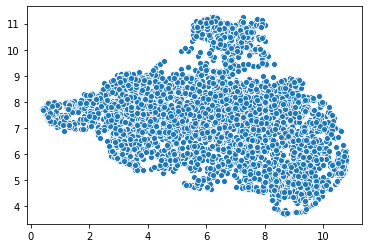

In [18]:
import seaborn as sns
sns.scatterplot(x=Xr_mean[:,0], y=Xr_mean[:,1])#, hue=list(map(lambda x: x, df.main_genre)))

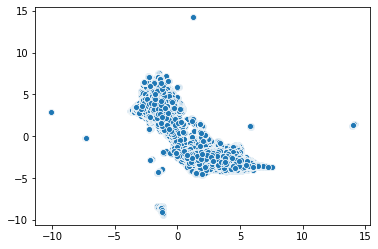

In [19]:
import seaborn as sns
sns.scatterplot(x=Xr_min[:,0], y=Xr_min[:,1])

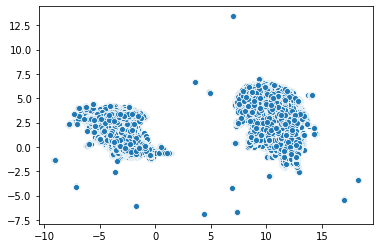

In [35]:
import seaborn as sns
sns.scatterplot(x=Xr_max[:,0], y=Xr_max[:,1])

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

Xr_mean_pca = pca.fit_transform(embeddings_mean)

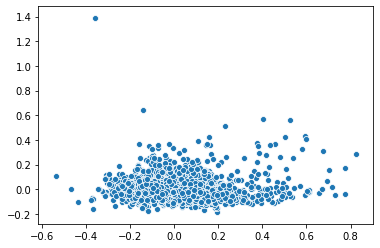

In [24]:
import seaborn as sns
sns.scatterplot(x=Xr_mean_pca[:,0], y=Xr_mean_pca[:,1])

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

Xr_min_pca = pca.fit_transform(embeddings_min)

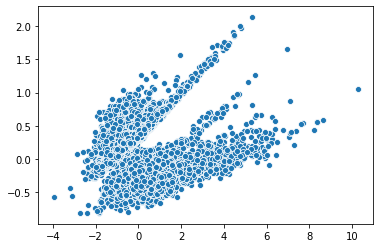

In [26]:
import seaborn as sns
sns.scatterplot(x=Xr_min_pca[:,0], y=Xr_min_pca[:,1])

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

Xr_max_pca = pca.fit_transform(embeddings_max)

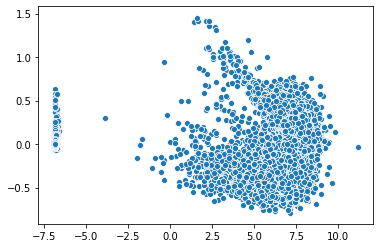

In [22]:
import seaborn as sns
sns.scatterplot(x=Xr_max_pca[:,0], y=Xr_max_pca[:,1])

In [47]:
from sklearn.cluster import DBSCAN, KMeans, 
from sklearn.mixture import GaussianMixture

clu = KMeans(n_clusters=2, n_jobs=-1)

labels = clu.fit_predict(embeddings_max)



/Users/lennartkeller/opt/anaconda3/envs/clustering/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


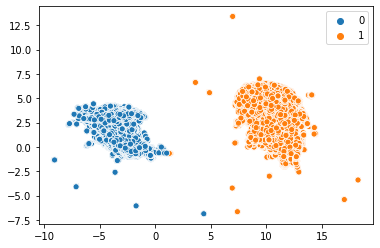

In [51]:
import seaborn as sns
sns.scatterplot(x=Xr_max[:,0], y=Xr_max[:,1], hue=labels)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(embeddings_max, labels)

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8653
           1       1.00      1.00      1.00      8593

    accuracy                           1.00     17246
   macro avg       1.00      1.00      1.00     17246
weighted avg       1.00      1.00      1.00     17246



In [53]:
embeddings_max.shape, df.shape

((68982, 300), (34491, 21))

In [85]:
ham_df = df[(df.writers.str.contains("nm1363595")) | (df.directors.str.contains("nm1363595"))].copy()
ham_df['Serie'] = ["Community" if entry.genre == "Comedy" else "Rick and Morty" for index, entry in ham_df.iterrows()]

In [86]:
ham_df

,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,...,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,main_region,main_genre,Serie
29778,3611170.xml,"Wie kann man das ausmachen ? Mama , kannst du ...",tt1467481,Comedy,2009.0,Unknown,untokenisiert,26,"nm0751577,nm0751648",nm1363595,...,Pilot,0.0,2009.0,NaN,26,7.8,3247.0,Other,Comedy,Community
29884,4303454.xml,Hey Man . Ich bin Jeff . Ich versuche meinen Z...,tt1480354,Comedy,2009.0,Unknown,untokenisiert,21,nm0751577,"nm1363595,nm0387684,nm0689390,nm1560199",...,Introduction to Film,0.0,2009.0,NaN,21,8.3,2755.0,Other,Comedy,Community
30065,3611172.xml,Guten Nachmittag Greendale Community College ....,tt1503241,Comedy,2009.0,Unknown,untokenisiert,22,nm0751648,"nm1363595,nm1560199",...,Spanish 101,0.0,2009.0,NaN,22,7.9,2817.0,Other,Comedy,Community
30181,3884736.xml,Guten Morgen Greendale Community College . Hie...,tt1515324,Comedy,2009.0,Unknown,untokenisiert,21,nm0751648,"nm1363595,nm2314834,nm1560199",...,Advanced Criminal Law,0.0,2009.0,NaN,21,7.9,2420.0,Other,Comedy,Community
30183,3884943.xml,Ein kleiner verblassender Rest eines Sterns . ...,tt1515325,Comedy,2009.0,Unknown,untokenisiert,21,nm0751648,"nm1363595,nm1417395,nm1560199",...,"Football, Feminism and You",0.0,2009.0,NaN,21,7.8,2377.0,Other,Comedy,Community
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54602,6398715.xml,"Hey , jetzt ist Golf einfach ! Aah ! Golf ist ...",tt4832266,"Adventure,Animation,Comedy",2015.0,Unknown,untokenisiert,24,"nm0033741,nm0585086","nm1551598,nm1363595,nm3171597,nm0572982,nm3452...",...,Get Schwifty,0.0,2015.0,NaN,24,8.3,8421.0,Other,Adventure,Rick and Morty
54604,6405278.xml,"Ich kann nicht glauben , dass wir eine Version...",tt4832268,"Adventure,Animation,Comedy",2015.0,Unknown,untokenisiert,23,"nm0585086,nm0688913","nm1551598,nm1363595,nm4155289,nm0572982,nm3452...",...,The Ricks Must Be Crazy,0.0,2015.0,NaN,23,9.3,10004.0,Other,Adventure,Rick and Morty
54606,6415235.xml,WELTRAUM-NOTAUFNAHME Macht euch keine Sorgen u...,tt4832274,"Adventure,Animation,Comedy",2015.0,Unknown,untokenisiert,23,"nm1090137,nm0585086","nm1551598,nm1363595,nm4155289,nm2466457,nm0572...",...,Interdimensional Cable 2: Tempting Fate,0.0,2015.0,NaN,23,7.7,8130.0,Other,Adventure,Rick and Morty
54608,6416163.xml,"Ich muss schon sagen , Rick . Es ist schon gei...",tt4832276,"Adventure,Animation,Comedy",2015.0,Unknown,untokenisiert,23,"nm0688913,nm0585086","nm1551598,nm1363595,nm2466457,nm0572982,nm6066...",...,Look Who's Purging Now,0.0,2015.0,NaN,23,8.6,8056.0,Other,Adventure,Rick and Morty


In [423]:
import re
remove_subcentral_annotation = re.compile(r'übersetzt von.+$', flags=re.I)
remove_season_episode_annotation = re.compile(r's\d+?e\d+?', flags=re.I)
remove_subcentral_note = re.compile(r'subcentral präsentiert.+$', flags=re.I)

In [424]:
ham_df.text = ham_df.text.str.replace(remove_subcentral_annotation, '')
ham_df.text = ham_df.text.str.replace(remove_season_episode_annotation, '')
ham_df.text = ham_df.text.str.replace(remove_subcentral_note, '')

In [307]:
ham_df.groupby('Serie').describe()

year                                                        \
               count        mean       std     min     25%     50%     75%   
Serie                                                                        
Community       58.0  2010.87931  1.612208  2009.0  2010.0  2010.5  2011.0   
Rick and Morty  18.0  2014.50000  0.923548  2013.0  2014.0  2014.5  2015.0   

                       isAdult       ... averageRating      numVotes  \
                   max   count mean  ...           75%  max    count   
Serie                                ...                               
Community       2014.0    58.0  0.0  ...         8.800  9.8     58.0   
Rick and Morty  2017.0    18.0  0.0  ...         8.975  9.6     18.0   

                                                                             \
                       mean          std     min      25%     50%       75%   
Serie                                                                         
Community       2531.896552   983.970130  1484.0  2107.00  2299.5   2727.75   
Rick and Morty  9591.833333  1922.953343  8056.0  8422.75  9143.0  10019.75   

                         
                    max  
Serie                    
Community        8344.0  
Rick and Morty  15868.0  

[2 rows x 48 columns]

In [19]:
import numpy as np
from flair.embeddings import DocumentRNNEmbeddings, WordEmbeddings, DocumentPoolEmbeddings, TransformerDocumentEmbeddings
from nltk.tokenize import sent_tokenize

doc_embeddings = TransformerDocumentEmbeddings('bert-base-german-cased')


from flair.data import Sentence
from tqdm import tqdm_notebook
embeddings = []

for index, row in tqdm_notebook(ham_df.iterrows()):
    sent_embeddings = []
    for sent in sent_tokenize(row.text):
        doc = Sentence(sent)
        doc_embeddings.embed(doc)
        sent_embedding = doc.embedding.cpu().detach().numpy()
        sent_embeddings.append(sent_embedding)
    embeddings.append(np.asarray(sent_embeddings))
len(embeddings)

<ipython-input-19-290612495fc3>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(ham_df.iterrows()):


76

In [348]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from stop_words import get_stop_words

tfidf = TfidfVectorizer(stop_words=get_stop_words('de'))
cv = CountVectorizer(stop_words=get_stop_words('de'))

cv_feat = cv.fit_transform(ham_df.text)
tfidf_feat = tfidf.fit_transform(ham_df.text)

In [207]:
from umap import UMAP

In [208]:
umap = UMAP(n_components=2)

Xr_cv = umap.fit_transform(cv_feat)

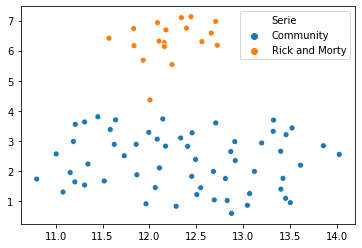

In [209]:
import seaborn as sns
sns.scatterplot(x=Xr_cv[:,0], y=Xr_cv[:,1], hue=ham_df.Serie)

In [210]:
print(ham_df[ham_df.year == 2017].text)

59854    Wie auch immer , so bin ich jedenfalls aus dem...
Name: text, dtype: object


In [211]:
umap = UMAP(n_components=2)

Xr_tfidf = umap.fit_transform(tfidf_feat)

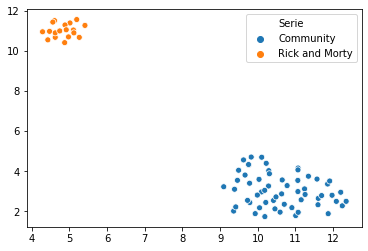

In [212]:
import seaborn as sns
sns.scatterplot(x=Xr_tfidf[:,0], y=Xr_tfidf[:,1], hue=ham_df.Serie)

In [213]:
mean_pooled = np.asarray([doc.mean(axis=0) for doc in embeddings])
max_pooled = np.asarray([doc.max(axis=0) for doc in embeddings])
min_pooled = np.asarray([doc.min(axis=0) for doc in embeddings])

In [248]:
UMAP_N_NEIGHBORS = 50

In [249]:
umap = UMAP(n_components=2, n_neighbors=UMAP_N_NEIGHBORS)

Xr_bert_mean = umap.fit_transform(mean_pooled)

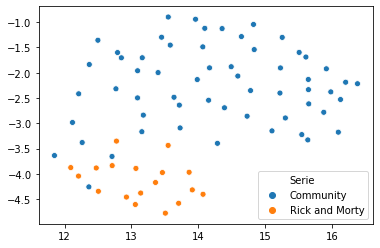

In [250]:
import seaborn as sns
sns.scatterplot(x=Xr_bert_mean[:,0], y=Xr_bert_mean[:,1], hue=ham_df.Serie)

In [251]:
umap = UMAP(n_components=2, n_neighbors=UMAP_N_NEIGHBORS)


Xr_bert_max = umap.fit_transform(max_pooled)

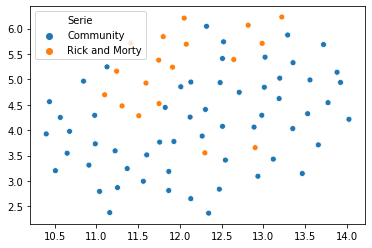

In [252]:
import seaborn as sns
sns.scatterplot(x=Xr_bert_max[:,0], y=Xr_bert_max[:,1], hue=ham_df.Serie)

In [253]:
umap = UMAP(n_components=2, n_neighbors=UMAP_N_NEIGHBORS)

Xr_bert_min = umap.fit_transform(min_pooled)

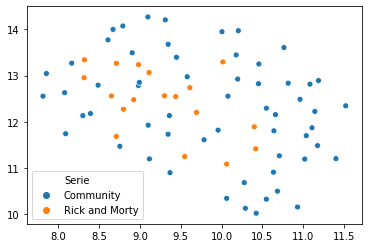

In [254]:
import seaborn as sns
sns.scatterplot(x=Xr_bert_min[:,0], y=Xr_bert_min[:,1], hue=ham_df.Serie)

In [436]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from stop_words import get_stop_words

tfidf = TfidfVectorizer(stop_words=get_stop_words('de'), ngram_range=(1,4))
cv = CountVectorizer(stop_words=get_stop_words('de'), ngram_range=(1,4))

cv_feat = cv.fit_transform(ham_df.text)
tfidf_feat = tfidf.fit_transform(ham_df.text)


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(cv_feat, ham_df.Serie, test_size=0.2)
clf = LogisticRegression(C=3.5).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


                precision    recall  f1-score   support

     Community       0.92      1.00      0.96        11
Rick and Morty       1.00      0.80      0.89         5

      accuracy                           0.94        16
     macro avg       0.96      0.90      0.92        16
  weighted avg       0.94      0.94      0.94        16



In [437]:
top_feat_community = np.argpartition(clf.coef_.ravel(), 20)[:20]
top_feat_rm = np.argpartition(clf.coef_.ravel(), -20)[-20:]

In [438]:
for tf in top_feat_community:
    print(dict(zip(cv.vocabulary_.values(), cv.vocabulary_.keys())).get(tf), tf, sep=' => ')

dekan => 14541
warum => 90894
annie => 3297
oh => 61865
pierce => 65409
community => 12403
spanisch => 78450
abed => 896
nein => 59439
greendale => 32855
morgen => 56235
weiß => 91712
danke => 13666
mal => 52825
jeff => 42781
tag => 81916
leute => 50386
troy => 84144
wer => 92783
schon => 73391


In [439]:
for tf in top_feat_rm:
    print(dict(zip(cv.vocabulary_.values(), cv.vocabulary_.keys())).get(tf), tf, sep=' => ')

anatomy park => 2701
and morty lawnmower dog => 2750
anatomy => 2700
lawnmower => 49204
park => 64396
rick and morty lawnmower => 69136
lawnmower dog => 49205
and morty lawnmower => 2749
morty lawnmower dog => 56636
morty lawnmower => 56635
dog => 15785
summer => 81270
rick => 69113
rick and => 69130
rick and morty => 69131
jerry => 43345
morty => 56335
and morty => 2740
scheiße => 72151
and => 2715


In [452]:
len(ham_df[ham_df.Serie == "Rick and Morty"].iloc[4].text)

37

In [461]:
for text in df[~df.text.apply(lambda x: len(x) < 100)].text:
    print(text)

.. : Planet of the Apes : .. .. : Season 1 Episode 2 " The Gladiators " : .. .. : 
ZWISCHEN ZWEI FRAUEN SÜDAMERIKA INTERNATIONALES REITGELÄNDE German 
Danke für Ihre Großzügigkeit . DER FASSADENKLETTERER TURBO-BESCHLEUNIGUNG German 
Staffel 1 Episode 08 A Game of Checkers 
Staffel 1 Episode 04 Capital P 
Episode 3 Gods Chillin - 
Staffel 1 Episode 07 Plan B 
Staffel 1 Episode 05 Straight Life 
board.tv4user.de 
Staffel 1 Episode 06 To Your Health 
board.tv4user.de - 
FROHES NEUES JAHR Geht ' s gut ? Geht so ... Stimmt was nicht ? Die Ameisen greifen an . 
Staffel 2 Episode 02 Ancient Tribes 
Oz Staffel 2 Episode 07 Animal Farm 
Oz Staffel 2 Episode 08 Escape from Oz 
Oz Staffel 2 Episode 05 Family Bizness 
Oz Staffel 2 Episode 04 Losing Your Appeal 
Oz Staffel 2 Episode 06 Strange Bedfellows 
Oz Staffel 3 Episode 06 Cruel and Unusual Punishments 
Oz Staffel 3 Episode 01 The Truth and Nothing But ... 
Oz Staffel 3 Episode 05 U.S. Male 
Oz Staffel 3 Episode 04 Unnatural Disasters 
Oz Sta

In [470]:
print(*df[df.text.apply(lambda x: len(x) < 500)].text, sep='\n\n\n')

Chaplin bei der Feuerwehr " Lass doch das Haus abbrennen . Dann krieg ich die Versicherung und du kannst meine Tochter heiraten . " Ein ehrliches Feuer " Kümmer ' dich nicht um dem Feueralarm . " 


Der Abenteurer Der Mann Jagd . Ein morgendliches Bad . Ihre tapferen Bewunderer . " Meine Mutter ! Rette sie ! " " Ich hörte Ihre Schreie von meiner Yacht ! " Ein müder Gast . Gekleidet in jemandes besten . STRAF ENTWEICHT CONVICT AT LARGE " Mein Vater ist Richter Brown . " " Mein Retter , Commodore Slick . " " Ihr Gesicht ist bekannt , Commodore ! " " Du brauchst eine Rasur ! " Die Gefängniswärter wird auch unterhalten werden . 


Die Heilquelle Die Gesundheit Frühling La molla della salute " Schütt ' diesen Likör weg ! " Das Gläschen nach dem Abendessen " Du bist der Nächste ! " Das Heilwasser hat eine komische Wirkung " Mit diesem Wasser bleibst du nüchtern ! " " Mir zuliebe ! " " Dir zuliebe ! " Am nächsten Morgen " Vergib mir ! Diese Quelle war voll Likör ! " " Bitte nicht ! " 


EASY 